In [1]:
# Running All Imports

import numpy as np
from numpy import ndarray
import matplotlib.pyplot as plt
%matplotlib inline

from qiskit import IBMQ, pulse

from qiskit.tools.monitor import job_monitor

from qiskit.visualization.pulse_v2 import stylesheet

from scipy.optimize import curve_fit

from typing import Optional

IBMQ.load_account()

/var/folders/g4/_yhz0jm50s17zz2ms7wwytcr0000gr/T/ipykernel_43402/2520264742.py:18: DeprecationWarning: The qiskit.IBMQ entrypoint and the qiskit-ibmq-provider package (accessible from 'qiskit.providers.ibmq`) are deprecated and will be removed in a future release. Instead you should use the qiskit-ibm-provider package which is accessible from 'qiskit_ibm_provider'. You can install it with 'pip install qiskit_ibm_provider'. Just replace 'qiskit.IBMQ' with 'qiskit_ibm_provider.IBMProvider'
  IBMQ.load_account()


<AccountProvider for IBMQ(hub='ibm-q', group='open', project='main')>

In [3]:
provider = IBMQ.get_provider(hub='ibm-q-nus', group='default', project='default')
# provider.backends()

DEBUG_PRINT = False

backend = provider.get_backend('ibm_cairo') # replace the name with the exact one for the backend that is desired from the previous displayed backends
backend_config = backend.configuration()
assert backend_config.open_pulse, "Backend doesn't support Pulse"

dt = backend_config.dt # Example way of getting data on the backend
backend_defaults = backend.defaults() 

acquire_alignment = backend.configuration().timing_constraints['acquire_alignment']
granularity = backend.configuration().timing_constraints['granularity']
pulse_alignment = backend.configuration().timing_constraints['pulse_alignment']

lcm = np.lcm(acquire_alignment, pulse_alignment)

# unit conversion factors -> all backend properties returned in SI (Hz, sec, etc.)
GHz = 1.0e9 # Gigahertz
MHz = 1.0e6 # Megahertz
us = 1.0e-6 # Microseconds
ns = 1.0e-9 # Nanoseconds

# Experiments will be run on these qubits
qubit_0 = 0
qubit_1 = 1

# The sweep will be centered around the estimated qubit frequency.
center_frequency_Hz_0 = backend_defaults.qubit_freq_est[qubit_0]
center_frequency_Hz_1 = backend_defaults.qubit_freq_est[qubit_1]

meas_freq_0 = backend_defaults.meas_freq_est[qubit_0]
meas_freq_1 = backend_defaults.meas_freq_est[qubit_1]

# scale factor to remove factors of 10 from the data
scale_factor = 1e-7

qubit = qubit_0

instruction_schedule_map = backend.defaults().instruction_schedule_map
measure_instructions = np.array(instruction_schedule_map.get("measure", qubits=[qubit]).instructions)
measure_pulse = measure_instructions[-2,1].pulse
measure_delay = measure_instructions[-1,1]

x_instructions = np.array(instruction_schedule_map.get("x", qubits=[qubit]).instructions)
x_pulse = x_instructions[0,1].pulse

sx_instructions = np.array(instruction_schedule_map.get("sx", qubits=[qubit]).instructions)
sx_pulse = sx_instructions[0,1].pulse

if DEBUG_PRINT:
    print(f"config: {backend_config}")

    for key, value in backend_config.to_dict().items():
        print(key)
        print(value)
    
    print(f"Sampling time: {dt*1e9} ns")    # The configuration returns dt in seconds, so multiply by
                                            # 1e9 to get nanoseconds

    backend_config.timing_constraints

    print(f"Least common multiple of acquire_alignment and pulse_alignment: {lcm}")

    print(f"Qubit {qubit_0} has an estimated frequency of {center_frequency_Hz_0 / GHz} GHz.")
    print(f"Qubit {qubit_1} has an estimated frequency of {center_frequency_Hz_1 / GHz} GHz.")

    print(f"Resonator for qubit {qubit_0} has an estimated frequency of {meas_freq_0 / GHz} GHz.")
    print(f"Resonator for qubit {qubit_1} has an estimated frequency of {meas_freq_1 / GHz} GHz.")

    print(f"measure_instructions: {measure_instructions}")

    print(f"measurement pulse: {measure_pulse}")
    print(f"measurement delay: {measure_delay}")
    print(f"x pulse: {x_pulse}")
    print(f"sx pulse: {sx_pulse}")

## Acquisition Scan Experiment

In [16]:
# Prototyping Acqusition Scan Class

from utils import *

acq_duration_dt = 48
acq_latency_dt = get_closest_multiple_of_16(get_dt_from(380 * ns))
acq_latency_sec = acq_latency_dt * dt

init_time_sec = 0.0 * ns
total_duration_sec = get_closest_multiple_of_16(get_dt_from(760 * ns)) * dt

fine_kappas_linspace = np.linspace(init_time_sec, total_duration_sec, int(get_dt_from(total_duration_sec - init_time_sec) / acq_duration_dt))
print(fine_kappas_linspace/ns)
print(len(fine_kappas_linspace))

[  0.          10.86984127  21.73968254  32.60952381  43.47936508
  54.34920635  65.21904762  76.08888889  86.95873016  97.82857143
 108.6984127  119.56825397 130.43809524 141.30793651 152.17777778
 163.04761905 173.91746032 184.78730159 195.65714286 206.52698413
 217.3968254  228.26666667 239.13650794 250.00634921 260.87619048
 271.74603175 282.61587302 293.48571429 304.35555556 315.22539683
 326.0952381  336.96507937 347.83492063 358.7047619  369.57460317
 380.44444444 391.31428571 402.18412698 413.05396825 423.92380952
 434.79365079 445.66349206 456.53333333 467.4031746  478.27301587
 489.14285714 500.01269841 510.88253968 521.75238095 532.62222222
 543.49206349 554.36190476 565.23174603 576.1015873  586.97142857
 597.84126984 608.71111111 619.58095238 630.45079365 641.32063492
 652.19047619 663.06031746 673.93015873 684.8        695.66984127
 706.53968254 717.40952381 728.27936508 739.14920635 750.01904762
 760.88888889]
71


In [17]:
def ss_acq_scan_exp(amp, fine_linspace):
    exp_g = []
    exp_e = []

    m_pulse = pulse.GaussianSquare(
        duration=measure_pulse.duration,
        amp=amp,
        sigma=measure_pulse.sigma,
        width=measure_pulse.width,
        angle=measure_pulse.angle,
        limit_amplitude=True
    )

    for kappa_delay_sec in fine_linspace:
        kappa_delay_dt = get_closest_multiple_of_16(get_dt_from(kappa_delay_sec))

        with pulse.build(backend=backend, default_alignment='left', name=f'acq scan g delay: {int(1e3*kappa_delay_sec/ns)/1e3}') as acq_g_sched:
            meas_chan = pulse.measure_channel(qubit)
            acq_chan = pulse.acquire_channel(qubit)

            pulse.delay(acq_latency_dt, meas_chan)
            pulse.play(m_pulse, meas_chan)
            pulse.delay(kappa_delay_dt, acq_chan)
            pulse.acquire(
                duration=acq_duration_dt,
                qubit_or_channel=acq_chan,
                register=pulse.MemorySlot(qubit)
            )
        exp_g.append(acq_g_sched)
        
        with pulse.build(backend=backend, default_alignment='left', name=f'acq scan e delay: {int(1e3*kappa_delay_sec/ns)/1e3}') as acq_e_sched:
            qubit_chan = pulse.drive_channel(qubit)
            meas_chan = pulse.measure_channel(qubit)
            acq_chan = pulse.acquire_channel(qubit)

            with pulse.align_right():
                pulse.delay(acq_latency_dt, meas_chan)
                pulse.play(x_pulse, qubit_chan)
            pulse.play(m_pulse, meas_chan)
            pulse.delay(kappa_delay_dt, acq_chan)
            pulse.acquire(
                duration=acq_duration_dt,
                qubit_or_channel=acq_chan,
                register=pulse.MemorySlot(qubit)
            )
        exp_e.append(acq_e_sched)
    return exp_g, exp_e

142


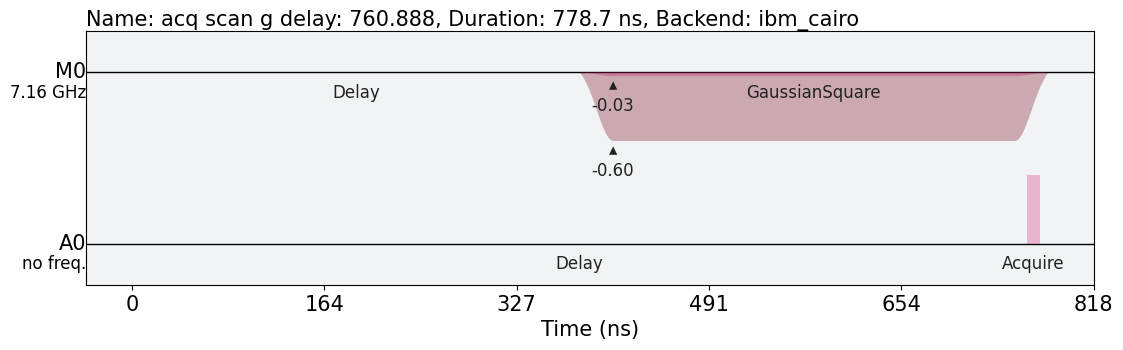

In [18]:
amps_linspace = np.array([measure_pulse.amp, 0.6])

all_exp_g = []
all_exp_e = []

for amp in amps_linspace:
    temp_g, temp_e = ss_acq_scan_exp(amp, fine_linspace=fine_kappas_linspace)
    all_exp_g.append(temp_g)
    all_exp_e.append(temp_e)

batch_g = flatten(all_exp_g)
batch_e = flatten(all_exp_e)

print(len(batch_g))

batch_g[-1].draw(
    backend=backend,
    style=stylesheet.IQXDebugging(),
    show_framechange=True,
    show_waveform_info=True,
    show_barrier=True
)

In [19]:
num_shots = 8192
rep_delay = 499.0 * 1e-6

big_exp = batch_g + batch_e
acquisition_checker(big_exp)
print(len(big_exp))

284


In [21]:
# Running exp_1, exp_2, exp_3, exp_4, and exp_5

job_experiment = backend.run(big_exp, 
                            meas_level=1, 
                            meas_return='single', 
                            shots=num_shots,
                            rep_delay=rep_delay)

job_monitor(job_experiment)

KeyboardInterrupt: 

In [22]:
job_1 = provider.backend.retrieve_job('crm0y2014ys000889xz0')

In [23]:
result_1 = get_results_arr(job_1.result(timeout=120), qubit=qubit)
print(result_1.shape)

(284, 4096)


In [24]:
result_1 = result_1.reshape(4, -1, num_shots)
res_normal_g = result_1[0]
res_high_g = result_1[1]
res_normal_e = result_1[2]
res_high_e = result_1[3]

In [25]:
fidelity_normal, sep_fidelity_normal = get_fidelity(res_normal_g, res_normal_e)
fidelity_high, sep_fidelity_high = get_fidelity(res_high_g, res_high_e)

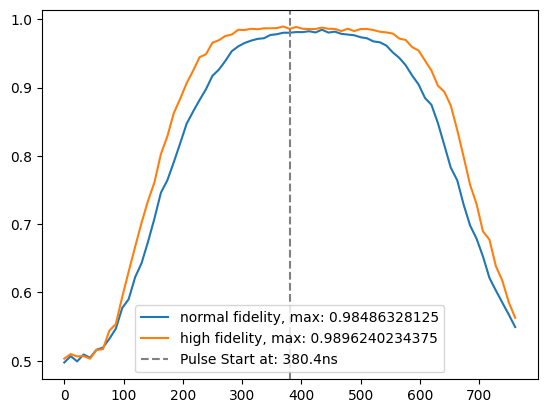

In [28]:
plt.plot(fine_kappas_linspace/ns, fidelity_normal, label=f'normal fidelity, max: {np.max(fidelity_normal)}')
plt.plot(fine_kappas_linspace/ns, fidelity_high, label=f'high fidelity, max: {np.max(fidelity_high)}')
plt.axvline(x=acq_latency_sec/ns, linestyle='dashed', color='grey', label=f'Pulse Start at: {np.round(acq_latency_sec/ns, 1)}ns')
plt.legend()
plt.show()